In [3]:
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
local_stringdb = os.path.join('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/string/lfs-stringdb/')
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()

# df = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
# df['alias'] = df['alias'].str.upper()
# aliases2stringId = df.set_index('alias')['#string_protein_id'].to_dict()
# name2stringId.update(aliases2stringId)
# stringnames = set(list(name2stringId.keys()))

In [4]:
# open pickle file in read mode
with open('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/co_exp/T3_sc_all_cell_coxp_matrix.pkl', 'rb') as f:
    # load data from pickle file
    st = pickle.load(f)
st_arr = st[0]
st_idx= st[1]

In [5]:
import scipy.sparse as sp

# create sparse matrix from st_arr_new
sparse_matrix = sp.csr_matrix(st_arr)

# get upper triangle as a sparse array
sparse_upper = sp.triu(sparse_matrix, k=1)
i, j, data = sp.find(sparse_upper)

col1 = st_idx[i]
col2 = st_idx[j]
df2 = pd.DataFrame({'combined_score': data})
df2['protein1'] = col1.values
df2['protein2'] = col2.values
df2['combined_score'] = df2['combined_score'].round(3)

In [9]:
df2.max()

combined_score    0.975
protein1          ZZEF1
protein2          ZZEF1
dtype: object

In [5]:
pos_idx = []
for pos, name in enumerate(st_idx):
    if name in name2stringId:
        pos_idx.append(pos)

In [6]:
st_arr_new = st_arr[np.ix_(pos_idx, pos_idx)]
st_idx_new  = [st_idx[i] for i in pos_idx]
st_idx_new = pd.Series(st_idx_new)

In [7]:
num_zeros = np.count_nonzero(st_arr_new == 0)

In [10]:
st_arr_new.shape

(18662, 18662)

In [11]:
(18662*18662-num_zeros)/2

113521684.5

In [8]:
len(st_idx_new)

18662

In [9]:
len(st_idx_new.map(name2stringId))

18662

In [55]:
import scipy.sparse as sp

# create sparse matrix from st_arr_new
sparse_matrix = sp.csr_matrix(st_arr_new)

# get upper triangle as a sparse array
sparse_upper = sp.triu(sparse_matrix, k=1)
i, j, data = sp.find(sparse_upper)


In [56]:
col1 = st_idx_new[i]
col2 = st_idx_new[j]
df2 = pd.DataFrame({'coexp_value': data})
df2['gene1'] = col1.values
df2['gene2'] = col2.values
df2['coexp_value'] = df2['coexp_value'].round(3)

In [36]:
# df2.loc[:,'protein1'] = df2['gene1'].map(name2stringId)
# df2.loc[:,'protein2'] = df2['gene2'].map(name2stringId)

In [58]:
df2.to_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/sc_all.csv',index=False)

In [3]:
import pandas as pd
import networkx as nx

In [4]:
stdf = pd.read_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/st_all.csv')

In [5]:
scdf = pd.read_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/sc_all.csv')

In [6]:
ppidf = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

In [7]:
ppi_g = nx.from_pandas_edgelist(ppidf, source='protein1', target='protein1', edge_attr='combined_score', create_using=nx.Graph)

In [15]:
len(ppi_g.edges())

18767

In [16]:
len(ppi_g.nodes())

18767

In [14]:
len(ppidf),len(stdf),len(scdf)

(1477610, 107293846, 113513298)

In [26]:
stnodes = np.union1d(stdf['gene1'].unique(), stdf['gene2'].unique())
len(stnodes)

17121

In [27]:
scnodes = np.union1d(scdf['gene1'].unique(), scdf['gene2'].unique())
len(scnodes)

16773

In [23]:
value_to_key = {key: value for value, key in name2stringId.items()}

In [28]:
ppinodes = np.array(list(map(value_to_key.get,ppi_g.nodes())))
len(ppinodes)

18767

In [17]:
len(np.intersect1d(stnodes, ppinodes)),len(np.intersect1d(stnodes, ppinodes)),len(np.intersect1d(stnodes, ppinodes))

19699

/novo/users/gzn/venepython3.9gzn/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


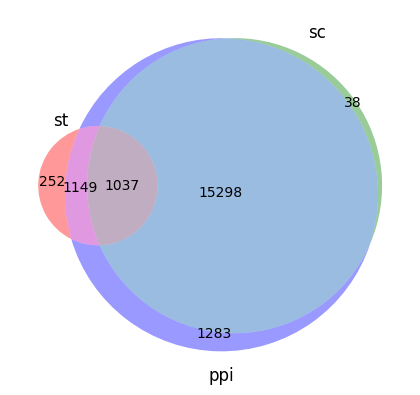

In [33]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# create three sets
set1 = set(stnodes)
set2 = set(scnodes)
set3 = set(ppinodes)

# get the counts of each section
counts = [len(set1 - set2 - set3), len(set2 - set1 - set3), len(set1 & set2 - set3), 
          len(set1 & set3 - set2), len(set2 & set3 - set1), len(set1 & set2 & set3), 
          len(set3 - set1 - set2)]

# plot the Venn diagram
venn3(subsets=counts, set_labels=('st', 'sc', 'ppi'))

# show the plot
plt.show()

In [5]:
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/st_chunk/st_'
chunk_size = len(scdf) // 3

# Split the DataFrame into 3 chunks
df1 = scdf.iloc[:chunk_size]
df2 = scdf.iloc[chunk_size:2*chunk_size]
df3 = scdf.iloc[2*chunk_size:]

# Save each chunk to a separate CSV file
df1.to_csv(root+'chunk_1.csv', index=False)
df2.to_csv(root+'chunk_2.csv', index=False)
df3.to_csv(root+'chunk_3.csv', index=False)

In [10]:
len(scdf['gene1'].unique())

17118

In [14]:
len(scdf)/len(graph)

69.27421637522049

In [12]:
graph = pd.read_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/sc_graph.csv')


In [11]:
len(graph['protein1'].unique())

18767

In [63]:
#df_dedup = df_dedup.rename(columns={'gene1': 'protein1', 'gene2': 'protein2'})

In [68]:
df_dedup.head(3)

,row,column,coexp_value,protein1,protein2
0,SAMD11,NOC2L,0.001015,9606.ENSP00000342313,9606.ENSP00000317992
1,SAMD11,KLHL17,0.000185,9606.ENSP00000342313,9606.ENSP00000343930
2,SAMD11,PLEKHN1,0.000000,9606.ENSP00000342313,9606.ENSP00000368720


In [69]:
graph['protein1'] = graph['protein1'].apply(lambda x: '9606.ENSP{:011d}'.format(x))
graph['protein2'] = graph['protein2'].apply(lambda x: '9606.ENSP{:011d}'.format(x))


In [71]:
graph = pd.merge(graph, df_dedup[['coexp_value', 'protein1', 'protein2']], how='left', on=['protein1', 'protein2'])

In [74]:
graph.to_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/st_graph.csv',index=False)

In [4]:
scpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/scrnaseq/scVI_Atherosclerosis_Atlas_V2.h5ad'
sc_dat = sc.read_h5ad(scpath)
sc_dat = sc_dat.raw.to_adata()
#sc_dat.obs['Disease'].unique()
# get disease data
disease_scdat = sc_dat[sc_dat.obs['Disease'] != 'Healthy']
# disease_scdat = sc_dat[sc_dat.obs['Disease'] != 'Healthy']
# normalize
#disease_scdat = disease_scdat.raw.to_adata()
disease_scdat.var_names_make_unique()
sc.pp.normalize_total(disease_scdat, target_sum=1e4)
disease_scdat = disease_scdat[:, disease_scdat.var_names.isin(list(stringnames))]

In [25]:
scgenes = disease_scdat.var_names.tolist()